# Genetic algorithm optimization of a silicon on-chip reflector

**Note: the cost of running the entire notebook is larger than 10 FlexCredits.**

A [genetic algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) (GA) is a search heuristic that mimics the process of natural selection. This algorithm reflects the process of natural evolution where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.

The steps in a GA are typically as follows:

1. **Initial Population**: The process begins with a set of individuals which is called a population. Each individual is a solution to the problem you want to solve.

2. **Fitness Function**: Each individual in the population has a fitness score which indicates how good it is at solving the problem.

3. **Selection**: The algorithm selects individuals, often the fittest among the population, to breed a new generation. The selection can be done in various ways, such as roulette wheel selection, tournament selection, etc.

4. **Crossover**: During crossover, parts of two individuals' chromosome strings are swapped to get a new offspring, which may contain some parts of both parents' strings. This simulates reproduction and biological crossover.

5. **Mutation**: In some new offspring, random genes are mutated or changed to maintain diversity within the population and to avoid premature convergence.

6. **New Generation**: The new generation of population is formed by the offspring. This new generation is then used in the next iteration of the algorithm.

7. **Termination**: The algorithm terminates if the population has converged (does not produce offspring that are significantly different from the previous generation), or a satisfactory solution has been found, or a set number of generations have been produced.

GAs have become a powerful tool for optimizing photonic components, leveraging their ability to efficiently search large and complex design spaces. In photonics, where the performance of components like waveguides, photonic crystals, and fibers can be highly sensitive to geometrical and material parameters, GAs offer a way to find optimal solutions that might be difficult to discover using traditional design methods. 

In this notebook, we demonstrate the optimization of a compact silicon waveguide reflector using GA, utilizing the open source Python library [pyGAD](https://pygad.readthedocs.io/en/latest/) implemented into the `Tidy3D` Design plugin. The idea follows `Zejie Yu, Haoran Cui, and Xiankai Sun, "Genetically optimized on-chip wideband ultracompact reflectors and Fabry–Perot cavities," Photon. Res. 5, B15-B19 (2017)` [DOI:10.1364/PRJ.5.000B15](https://doi.org/10.1364/PRJ.5.000B15). The design region of the reflector consists of a grid divided into 18x18 pixels. Each pixel is a square measuring 120 nm by 120 nm. 

<img src="img/optimized_reflector.png" width="450" alt="Schematic of the reflector">

`Tidy3D` is a powerful tool for photonic design optimization due to its fast speed and high throughput. Besides GA, we have demonstrated particle swarm optimizations of a [polarization beam splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/ParticleSwarmOptimizedPBS/) and a [bullseye cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/), CMA-ES optimization of an [waveguide S-bend](https://www.flexcompute.com/tidy3d/examples/notebooks/SbendCMAES/), Bayesian optimization of a [Y-junction](https://www.flexcompute.com/tidy3d/examples/notebooks/BayesianOptimizationYJunction/), and direct binary search optimization of an [optical switch](https://www.flexcompute.com/tidy3d/examples/notebooks/OpticalSwitchDBS/). Furthermore, we also have a growing list of gradient-based adjoint optimization examples including

1. [Mode converter](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/),

2. [Waveguide taper](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/),

3. [Metalens](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin7Metalens/),

4. [Waveguide bend](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin8WaveguideBend/), 

5. [Multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin9WDM/),

6. [Y-branch](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin10YBranchLevelSet/),

7. [MZI circuit](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin11CircuitMZI/),

8. [Light extractor](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin12LightExtractor/).

In [1]:
# Uncomment the following line to install pygad if it's not installed in your environment already
# pip install pygad

import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd

## Simulation Setup

For simplicity, we will use the silicon and oxide media directly from the [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html#).

In [2]:
Si = td.material_library["cSi"]["Palik_Lossless"]
SiO2 = td.material_library["SiO2"]["Palik_Lossless"]

The simulation wavelength range is 1450 nm to 1650 nm.

In [3]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.45, 1.65, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

The waveguide has a 500 nm width and 220 nm thickness. The design region consists of 18 by 18 pixels. Each pixel is 120 nm by 120 nm. Due to the symmetry, we only consider symmetric design so the total number of tunable pixels is 18*9=162.

In [4]:
w = 0.5  # width of the waveguide
t = 0.22  # thickness of the silicon
l = 1  # length of the waveguide in the simulation
Px = Py = 0.12  # pixel sizes in the x and y directions
Nx = 18  # number of pixels in the x direction
Ny = 9  # numbre of pixels in the y direction
buffer = 0.8  # buffer spacing
res = 15 # overall resolution setting (steps per wavelength)
gsx = gsy = 5 # number of grid steps per pixel in override region

We will create an array of length 162 to represent a design. Each element corresponds to each pixel in the design region. An element value of 1 means the pixel is silicon while an element value of 0 means the pixel is void. To facilitate the optimization, we define a helper function `create_design(pixels)` that takes the pixel array and creates the [Structures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html) of the simulation, inlcuding the waveguide and the design region. 

In [5]:
def create_design(pixels):
    geo = 0
    for i, pixel in enumerate(pixels):
        if pixel == 1:
            geo += td.Box(
                center=(l + Px / 2 + Px * (i % Nx), Py * Ny - Py / 2 - Py * (i // Nx), t / 2),
                size=(Px, Py, t),
            )
            geo += td.Box(
                center=(l + Px / 2 + Px * (i % Nx), -(Py * Ny - Py / 2 - Py * (i // Nx)), t / 2),
                size=(Px, Py, t),
            )
    geo = geo + td.Box(center=(0, 0, t / 2), size=(2 * l, w, t))

    design = td.Structure(geometry=geo, medium=Si)

    return design

As a quick check, we create a random array and plot the created structures.

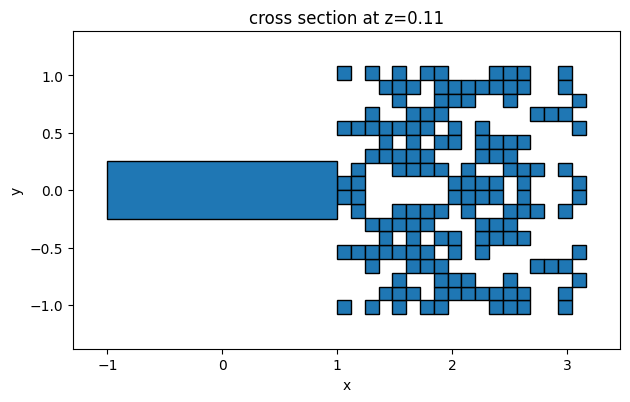

In [6]:
pixels = np.random.choice([0, 1], size=Nx * Ny)
design = create_design(pixels)
design.plot(z=t / 2)
plt.show()

Furthermore, we define a `make_sim(pixels)` function to define the entire simulation given the pixel array. The simulation includes a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) to launch the TE0 mode at the waveguide and a [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) next to the source to measure the reflection. To minimize data download during the optimization, we will only record the reflection at the central wavelength of 1550 nm since the objective is to maximize this value. 

In [7]:
def make_sim(pixels):

    design = create_design(pixels)

    # Add a mode source as excitation
    mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
    mode_source = td.ModeSource(
        center=(l / 2, 0, t / 2),
        size=(0, 4 * w, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
    )

    # Add a mode monitor to measure transmission at the output waveguide
    mode_monitor = td.ModeMonitor(
        center=(l / 4, 0, t / 2),
        size=mode_source.size,
        freqs=[freq0],
        mode_spec=mode_spec,
        name="mode",
    )

    # Define simulation domain size
    Lx = l + Nx * Px + buffer
    Ly = 2 * Ny * Py + 2 * buffer
    Lz = 10 * t

    eff_inf = 1e2  # effective infinity

    # Define substrate structure
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-eff_inf, -eff_inf, -eff_inf), rmax=(eff_inf, eff_inf, 0)
        ),
        medium=SiO2,
    )

    run_time = 5e-13  # simulation run time

    # Simulation box
    sim_box = td.Box.from_bounds(rmin=(0, -Ly / 2, -Lz / 2), rmax=(Lx, Ly / 2, Lz / 2))

    # Mesh override structure over the pixel region to ensure grid that conforms to the pixels
    mesh_override = td.MeshOverrideStructure(
        geometry=td.Box.from_bounds(rmin=(l, -Py * Ny, 0), rmax=(l + Px * Nx, Py * Ny, 0)),
        dl=(Px / gsx, Py / gsy, 1), # the z-direction dl doesn't matter as the box size is 0 along z
    )

    # Define simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=res, wavelength=lda0, override_structures=[mesh_override]),
        structures=[design, substrate],
        sources=[mode_source],
        monitors=[mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        symmetry=(0, -1, 0),
    )

    return sim

Again, we test it by defining a simulation with a random pixel array. From the 3D view, we confirm that the simulation setup is correct.

In [8]:
sim = make_sim(pixels)
sim.plot_3d()

## GA Setup

Now we are ready to setup a GA optimization. This can quickly be done using the Tidy3D `Design` plugin, which can efficiently manage the optimization with parallel cloud computing, reducing the runtime and saving FlexCredits.

First we need to define some hyperparameters. In this particular example, we will use 30 solutions per population and run the optimization for a total of 25 generations, and also specify early-stop criteria that stops the optimization if the fitness value doesn't change for 6 consecutive generations. The `MethodGenAlg` class can be used to tune a number of parameters that change the selection, crossover, and mutation processes. We only change a few and leave the most to the default settings. Users are encouraged to explore these settings using the [PyGAD](https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class) docs and fine tune them for better results. For reproducibility, we also set a fixed random seed.

A list `ParameterInt` objects are created to store the binary values used to define the geometry of the reflector. These parameters and the GA method are supplied to a `DesignSpace` object, which manages the GA process and outputs the results of the optimization.

In [9]:
method = tdd.MethodGenAlg(
    solutions_per_pop=30, 
    n_generations=25,
    n_parents_mating=10,
    keep_elitism=1,
    parent_selection_type="sss",
    crossover_type="single_point",
    crossover_prob=0.7,
    mutation_type="inversion",
    mutation_prob=None,
    seed=5,
    stop_criteria_type="saturate",
    stop_criteria_number=6,
)

parameters = [tdd.ParameterInt(name=i, span=(0, 1)) for i in range(Nx * Ny)]

design_space = tdd.DesignSpace(method=method, parameters=parameters, task_name="GA_Notebook", path_dir="./data")

We can optionally summarise the design space to check the setup.

In [ ]:
summary = design_space.summarize()

To run the GA optimization we need to define the `fn_pre` and `fn_post` functions for the optmizer. The pre function creates a `Simulation` from the parameters suggested by GA as a solution to the reflector. The post function defines how the `SimulationData` should be evaluated to create a single float value which is then fed back into the GA. By evaluating of the float values of the current generation the GA can then assemble the population for the next generation, based on our hyperparameters.

In [10]:
def fn_pre(**params):
    pixels = np.array(list(params.values()))
    sim = make_sim(pixels)
    
    return sim

def fn_post(sim_data):
    return abs(sim_data["mode"].amps.sel(direction="-").squeeze(drop=True).values) ** 2

Once satisfied with the setup, the optimization can be started by calling `DesignSpace.run` with our `fn_pre` and `fn_post` functions. The `DesignSpace` will parallelize each generation by running the `Simulation` objects as a batch, and will prevent previously evaluated solutions from being recomputed. Once complete, we can combine all the solution outputs within a Pandas `DataFrame` for further analysis.

In [11]:
results = design_space.run(fn_pre, fn_post, verbose=True)
df = results.to_dataframe()

09:41:57 BST Running 30 Simulations

09:43:21 BST Running 29 Simulations

09:44:43 BST Generation 1 Best Fitness: 0.723

09:44:44 BST Running 29 Simulations

09:46:02 BST Generation 2 Best Fitness: 0.760

09:46:03 BST Running 29 Simulations

09:49:36 BST Generation 3 Best Fitness: 0.760

09:49:37 BST Running 29 Simulations

09:50:59 BST Generation 4 Best Fitness: 0.760

09:51:00 BST Running 29 Simulations

09:52:25 BST Generation 5 Best Fitness: 0.765

09:52:26 BST Running 29 Simulations

09:53:47 BST Generation 6 Best Fitness: 0.765

             Running 29 Simulations

09:55:12 BST Generation 7 Best Fitness: 0.784

             Running 29 Simulations

09:56:32 BST Generation 8 Best Fitness: 0.784

09:56:33 BST Running 29 Simulations

09:57:51 BST Generation 9 Best Fitness: 0.803

09:57:52 BST Running 29 Simulations

09:59:08 BST Generation 10 Best Fitness: 0.816

09:59:09 BST Running 29 Simulations

10:00:30 BST Generation 11 Best Fitness: 0.816

10:00:31 BST Running 29 Simulations

10:01:46 BST Generation 12 Best Fitness: 0.829

10:01:47 BST Running 29 Simulations

10:03:05 BST Generation 13 Best Fitness: 0.829

10:03:06 BST Running 29 Simulations

10:04:24 BST Generation 14 Best Fitness: 0.829

10:04:25 BST Running 29 Simulations

10:05:44 BST Generation 15 Best Fitness: 0.866

10:05:45 BST Running 29 Simulations

10:07:03 BST Generation 16 Best Fitness: 0.866

10:07:04 BST Running 29 Simulations

10:08:18 BST Generation 17 Best Fitness: 0.912

10:08:19 BST Running 29 Simulations

10:09:39 BST Generation 18 Best Fitness: 0.912

10:09:40 BST Running 29 Simulations

10:10:57 BST Generation 19 Best Fitness: 0.912

10:10:58 BST Running 29 Simulations

10:12:18 BST Generation 20 Best Fitness: 0.912

10:12:19 BST Running 29 Simulations

10:13:40 BST Generation 21 Best Fitness: 0.912

10:13:41 BST Running 29 Simulations

10:15:00 BST Generation 22 Best Fitness: 0.912

10:15:01 BST Running 29 Simulations

10:16:16 BST Generation 23 Best Fitness: 0.912

             Best Result: 0.912478548154955                                     
             Best Parameters: 0: 1 1: 1 2: 0 3: 0 4: 0 5: 0 6: 0 7: 1 8: 0 9: 0 
             10: 1 11: 1 12: 0 13: 0 14: 0 15: 0 16: 0 17: 1 18: 1 19: 1 20: 0  
             21: 1 22: 1 23: 0 24: 0 25: 0 26: 1 27: 0 28: 1 29: 1 30: 1 31: 1  
             32: 1 33: 1 34: 0 35: 0 36: 1 37: 1 38: 0 39: 0 40: 1 41: 1 42: 0  
             43: 1 44: 0 45: 1 46: 1 47: 1 48: 0 49: 1 50: 1 51: 1 52: 1 53: 1  
             54: 0 55: 0 56: 0 57: 1 58: 1 59: 0 60: 1 61: 0 62: 1 63: 1 64: 0  
             65: 0 66: 1 67: 0 68: 0 69: 0 70: 0 71: 0 72: 0 73: 1 74: 0 75: 0  
             76: 1 77: 1 78: 0 79: 0 80: 0 81: 1 82: 0 83: 1 84: 0 85: 0 86: 0  
             87: 1 88: 1 89: 0 90: 1 91: 1 92: 0 93: 0 94: 1 95: 1 96: 0 97: 1  
             98: 0 99: 0 100: 0 101: 1 102: 0 103: 1 104: 0 105: 1 106: 1 107: 0
             108: 1 109: 1 110: 1 111: 1 112: 1 113: 0 114: 0 115: 1 116: 1 117:
             1 118: 1 119: 0 120: 0 121: 1 122: 0 123: 1 124: 0 125: 1 126: 1   
             127: 1 128: 1 129: 0 130: 1 131: 0 132: 1 133: 0 134: 1 135: 0 136:
             0 137: 1 138: 1 139: 0 140: 1 141: 1 142: 0 143: 0 144: 0 145: 1   
             146: 1 147: 0 148: 1 149: 1 150: 1 151: 1 152: 1 153: 1 154: 0 155:
             0 156: 1 157: 1 158: 0 159: 1 160: 1 161: 0                        
             

## Optimization and Results

The optimization prints the best fitness achieved in after the generation has been computed. We can further visualize this improvement using the optimizer object stored in the ``results``. After the optimization is complete, we see that we achieved the best fitness (reflection) of 0.897.

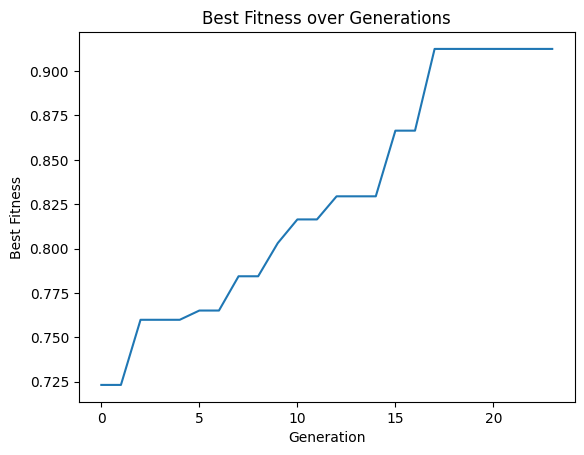

Fitness value of the best solution = 0.912


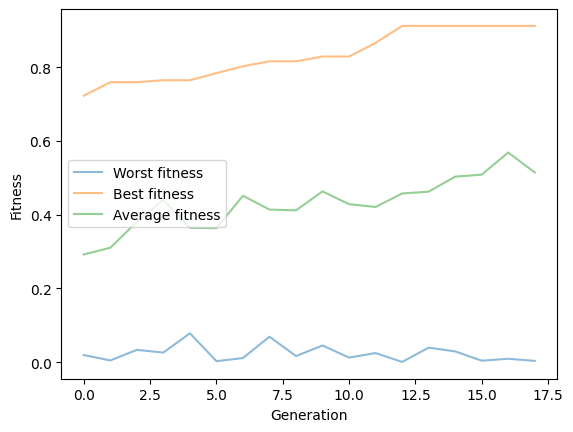

In [12]:
# Plotting the best fitness over generations
ga_instance = results.optimizer
best_fitness = ga_instance.best_solutions_fitness
generations = range(len(best_fitness))

plt.plot(generations, best_fitness)
plt.title("Best Fitness over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.show()

pixels_final, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness value of the best solution = {solution_fitness:.3f}")

def plot_fitness_evolution(data_frame, solutions_per_pop, fitness_column_name="output"):
    """Plot the best, worst, and average fitness across generations."""

    # Divide the solutions into generations
    fitness_values = data_frame[fitness_column_name]
    generation_fitness = [fitness_values[i: i + solutions_per_pop] for i in range(0, len(fitness_values), solutions_per_pop)]

    # Get min, max, and mean values per generation
    min_fitness = [generation.min() for generation in generation_fitness]
    max_fitness = [generation.max() for generation in generation_fitness]
    mean_fitness = [generation.mean() for generation in generation_fitness]

    plt.plot(min_fitness, label="Worst fitness", alpha=0.5)
    plt.plot(max_fitness, label="Best fitness", alpha=0.5)
    plt.plot(mean_fitness, label="Average fitness", alpha=0.5)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()

plot_fitness_evolution(df, 40)

Now that we have an optimized design, we will grab the best pixel array and re-simulate the design with a broadband [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) and a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) at the central wavelength. This final simulation can be defined by copying the original simulation and updating the monitors.

In [13]:
sim_final = make_sim(pixels_final)

# Update mode monitor's recording frequencies
mode_monitor = sim.monitors[0].copy(update={"freqs": freqs})

# Add a field monitor to visualize field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, t / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# Update simulation to use the new monitors
sim_final = sim_final.copy(update={"monitors": [mode_monitor, field_monitor]})

# Submit the simulation to the server
sim_data_final = web.run(simulation=sim_final, task_name="final design")

10:38:04 BST Created task 'final design' with task_id                           
             'fdve-b96bb239-29e0-4358-ad9a-b87283aa576e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=398467;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=472845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\taskId]8;;\]8;id=398467;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\=]8;;\]8;id=192710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\fdve]8;;\]8;id=398467;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\-b96bb239-29e]8;;\
             ]8;id=398467;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\0-4358-ad9a-b87283aa576e']8;;\.

Output()

10:38:07 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:38:23 BST status = preprocess

10:38:26 BST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

10:38:36 BST early shutoff detected at 48%, exiting.

10:38:37 BST status = postprocess

Output()

10:38:38 BST status = success

10:38:39 BST View simulation result at                                          
             ]8;id=540161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=269756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\taskId]8;;\]8;id=540161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\=]8;;\]8;id=951144;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\fdve]8;;\]8;id=540161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\-b96bb239-29e]8;;\
             ]8;id=540161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b96bb239-29e0-4358-ad9a-b87283aa576e\0-4358-ad9a-b87283aa576e']8;;\.

Output()

10:38:41 BST loading simulation from simulation_data.hdf5

After the simulation, we visualize the electric field norm at the central wavelength. As expected, a strong reflection is observed. 

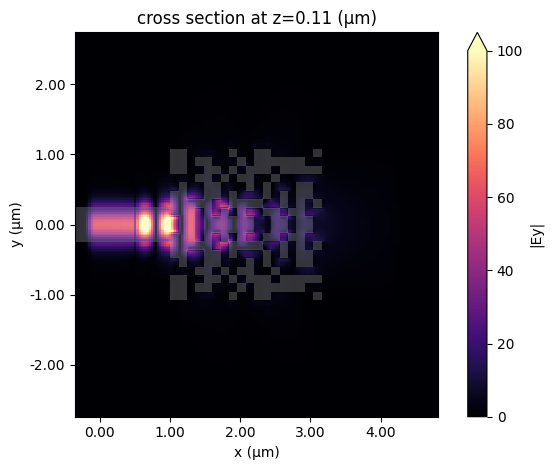

In [14]:
sim_data_final.plot_field("field", "Ey", "abs", vmin=0, vmax=1e2)
plt.show()

Finally plot the reflection spectrum, where we see a broadband reflection. Considering the very compact footprint, the performance is very good. With this reflector design, we can further construct other devices such as high-quality-factor Fabry–Perot cavities as demonstrated in the [publication](https://doi.org/10.1364/PRJ.5.000B15).

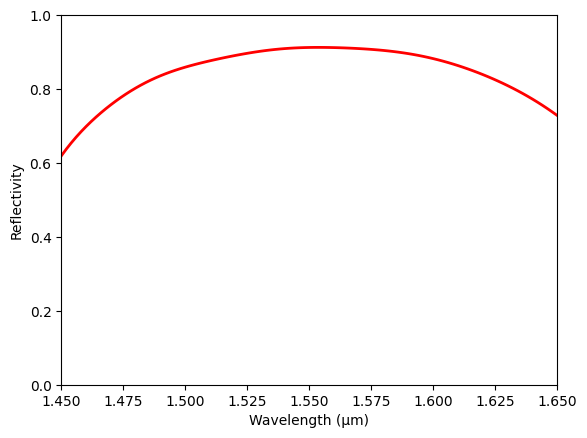

In [15]:
R = abs(sim_data_final["mode"].amps.sel(direction="-").squeeze(drop=True).values) ** 2

plt.plot(ldas, R, "red", linewidth=2)
plt.xlim(min(ldas), max(ldas))
plt.ylim(0, 1)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectivity")
plt.show()

With the optimized design, we can directly export a GDS file of the reflector for fabrication. 

In [16]:
# Make the misc/ directory to store the GDS file if it doesnt exist already
import os
if not os.path.exists('./misc/'):
    os.mkdir('./misc/')
    
sim_final.to_gds_file(fname="misc/optimized_reflector.gds", z=t / 2)